In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../Data/www/styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Synopsis

So far we've covered the basics of what constitutes an image, color is encoded, and how we can manipulate it. However, when you conduct research the tasks you need to perform are typically more complex (although they always seem easy to do before you start coding!). Some examples of common tasks are:

* Automatically identify regions
* Identify the borders of areas
* Find bright spots/blobs
* Skeletonize shapes (i.e. find the backbone)

We'll go over some basic methods to do some of these methods using `scikit-image`. The `scikit-image` package is a sister to the `scikit-learn` package, both of these packages are focused on implementing machine-learning methods in Python but `scikit-image`, as you probably guessed, is geared towards algorithms that can be applied to images. 

## Identifying image borders

One common technique researchers will want to use is identifying the edge of certain regions. This is useful in a number of contexts, such as:

* Identifying the borders of cells in a microscope image
* Finding areas in geographic areas

This procedure is typically called contour finding and we can use an algorithm that is implemented in `scikit-image`.

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import imshow, imread

from skimage import measure

To start with we'll generate some test data using some random numbers and then applying `sine` and `cosine` functions to regularly transform it.

(100, 100)


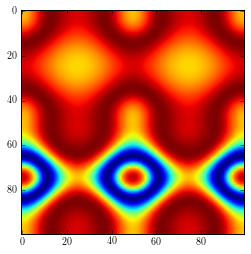

In [10]:
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

print( r.shape )

imshow(r)

Next we can use a contour finding algorithm. In `scikit-image` there is the `find_contours` algorithm that is an implementation of the [marching squares algorithm](http://users.polytech.unice.fr/~lingrand/MarchingCubes/algo.html). This algorithm constructs the image as a grid and attempts to draw lines along the edges of the squares in the grid. 

[]

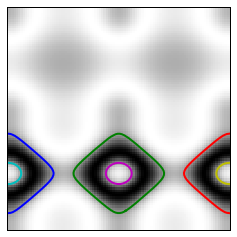

In [14]:
contours = measure.find_contours(r, 0.2)

#Now plot the image and contours
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap = plt.cm.gray)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

Excellent! That was pretty easy....but what really happened? 

So let's break this apart - the `find_countours` algorithm takes two arguments - the 2D image array (must be 2D since this is a special case of the algorithm) and the `level` value. This `level` controls the value around which the algorithm should attempt to find the contours - this is our free parameter.  

Now transform the above code into a function and lets see how much changing the `level` affects our identification of surfaces with the algorithm.

In [ ]:
#Your code here


Wow! Not really so simple after all......We can see that the result drastically changes as we increase the level. 

Not so easy after all, huh?

So this can work when we have a series of similar images when we are interested in, generally, extracting the same feature for further analysis but would fall flat if we were trying to apply it to a series of different images.

We can show this with the Picasso images. 

In [1]:
from PIL import Image

picasso_img = Image.open('../Data/Day8-Image-Analysis/Picasso/1895-First_Communion.-11.jpg')
bw_picasso_img = np.array( picasso_img.convert('L') )

fig = plt.figure(figsize = (9, 6))
ax1 = fig.add_subplot(121)
imshow(picasso_img)
ax2 = fig.add_subplot(122)
imshow(bw_picasso_img, cmap = plt.cm.gray)

NameError: name 'np' is not defined

In [55]:
print(bw_picasso_img)

[[ 44  44  43 ..., 130 148 159]
 [ 33  32  31 ..., 122 128 131]
 [ 28  28  27 ..., 113 114 115]
 ..., 
 [ 73  71  69 ...,  91  89  88]
 [ 83  81  78 ...,  90  90  90]
 [ 92  90  87 ...,  89  90  91]]


Let's see how it works with our contour finding algorithm

In [53]:
#Your code here


Slower when it's a real image!So slow, because it found so many contours that aren't really useful at all!

When using real images we frequently need to apply some additional filtering techniques to the image so that it is amenable to further analysis. One technique is thresholding the image and transforming it into a strict black and white image (instead of grayscale). 

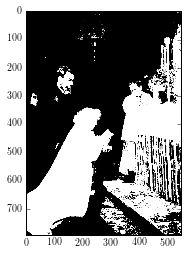

In [114]:
def binarize_image(inimg, threshold):
    img = inimg[:]
    img[img>threshold] = 255
    img[img<=threshold] = 0
    return img

imshow( binarize_image(bw_picasso_img, 100) , cmap = plt.cm.gray)

Using the threshold we could actually define areas of the image rather simply - if it's a continous area of pixels that are all 0 - then it's a region. Otherwise, it's a different region (hopefully this is the same that the contour algorithm would do!).

Let's try to find contours again but with the thresholded image. 

In [115]:
#Your code here


A little bit better and quicker! There's still lots and lots of noisy contours though....to make any use of this we would still need to filter the regions based on size and only include contours that are of a certain area.

In [117]:
contours = measure.find_contours(binarize_image(bw_picasso_img, 100), 200)

In [118]:
contours[0]

array([[   0.        ,  513.21568627],
       [   1.        ,  513.21568627],
       [   2.        ,  513.21568627],
       [   2.21568627,  513.        ],
       [   2.21568627,  512.        ],
       [   2.        ,  511.78431373],
       [   1.        ,  511.78431373],
       [   0.        ,  511.78431373]])

Now write code to get the area of any contour set. You can refer to this [page](http://www.mathopenref.com/coordpolygonarea.html) for the formulation.

In [119]:
#Your code here


We can see that most of the contours have no area. So now let's restrict the contours based on size and only plot contours with a non-zero area.

In [121]:
#Your code here


AHHHHHH! Much better! We could even increase our threshold on the area size to improve it. Where should we set the threshold on area size? How should we look at that?

In [82]:
#Your code here


So where should we set the area threshold?

In [88]:
#Your code here


## More "intelligent" filtering and binning

We applied a very simple threshold - how could we apply thresholds in a more complex manner to preserve some of the image complexity?

We could always bin the values and quantize them in some method.  Let's look at the histogram of the original black and white image values.

In [128]:
#Your code


A different approach to a simple threshold would be to quantize the image, i.e. bin the values in the image and assign every value in each bin the same value. 

There are many, many ways to partition this histogram into discrete bins.

We could do this manually, but I'd like to employ a machine-learning algorithm called K-means. K-means returns the number of clusters that you give it - so it is rather imperfect, and we're not going to go deep into its validation, but it is an easy way to start working.

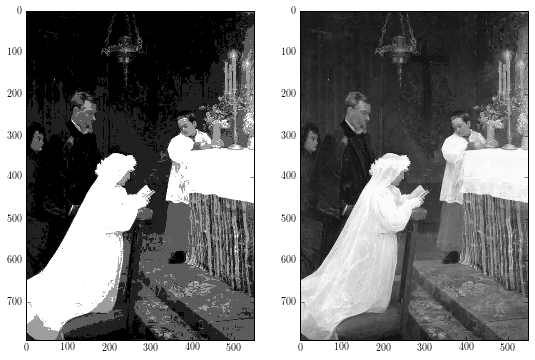

In [133]:
from sklearn import cluster
picasso_img = Image.open('../Data/Day8-Image-Analysis/Picasso/1895-First_Communion.-11.jpg')
bw_picasso_img = np.array( picasso_img.convert('L') )
X = bw_picasso_img.reshape((-1, 1))
kmeans = cluster.KMeans(n_clusters = 5, n_init = 1)
kmeans.fit(X)
values = kmeans.cluster_centers_.squeeze()
labels = kmeans.labels_
compressed_img = np.choose(labels, values)
compressed_img.shape = bw_picasso_img.shape
#Plot it out
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(121)
imshow(compressed_img, cmap = plt.cm.gray)
#Raw image
ax = fig.add_subplot(122)
imshow(bw_picasso_img, cmap = plt.cm.gray)

Here we can see the results with the smoothing of the different areas of the image. 

Now we could always try to apply the contour finding to this image.

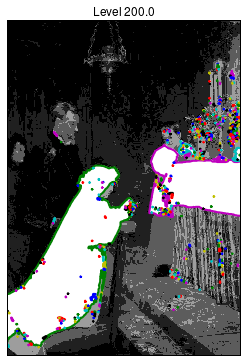

In [140]:
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111)
find_contour(ax, compressed_img, 200)

A little bit better it looks like!